## MyConnectome analyses

In this notebook we will examine various analyses of the resting fMRI data from the MyConnectome study.  

### Predicting mood and fatigue from resting connectivity

After each resting scan, the subject completed a Positive and Negative Affect Scale (PANAS) which provides measures of positive and negative mood and arousal.  In this exercise we will attempt to predict mood measures from functional connectivity estimated from resting fMRI. The fmri data were first projected onto the surface and then averaged within a set of 616 cortical regions identified using surface-based parcellation, as well as 14 subcortical regions.  The mean fMRI signal was then extracted from each of those regions for each time point.  See Laumann et al. (2015, *Neuron*) for more details on data processing.

In [1]:
import os
import numpy
import pandas
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
import nilearn.plotting

import cairocffi # needed for igraph plotting on Mac
import igraph

from get_balanced_folds import BalancedKFold

# if data don't exist then download them
if not os.path.exists('data'):
    # download the data
    import requests,tarfile
    print('no data directory, downloading the data...')
    url = "http://web.stanford.edu/group/poldracklab/myconnectome-example/data.tgz"
    filename = url.split("/")[-1]
    with open(filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
    print('unpacking data.tgz')
    file = tarfile.open('data.tgz', 'r:gz')
    file.extractall()
    file.close()
    os.remove('data.tgz')

# set this to the location of the datafiles on your system
datadir='data'
assert os.path.exists(datadir)

# load the correlation data. This matrix contains
# the upper triangle of the correlation matrix between each of the 630
# regions, across each of the 84 good sessions
corrdata=numpy.load(os.path.join(datadir,'rsfmri/corrdata.npy'))

# load the behavioral data, which includes the PANAS scores
behavdata=pandas.read_csv(os.path.join(datadir,'trackingdata_goodscans.txt'),
                         header=0,sep='\t',na_values='.')
# reduce to the three that we will work with
behavdata=behavdata[['panas:positive','panas:negative','panas:fatigue']]

# load information about the regions (which we call "parcels")
parceldata=pandas.read_csv(os.path.join(datadir,'parcel_data.txt'),
                          header=None,sep='\t')
parceldata.replace(to_replace='na', value='Subcortical', inplace=True)
parceldata.replace(to_replace='Zero', value='Unassigned', inplace=True)


Now let's create a function that will predict panas scores from connectivity matrices.  Here we use a special crossvalidation operator that implements balanced cross validation for continuous variables, which basically ensures that every crossvalidation fold has a roughly similar distribution on the Y variable.  If we don't do this, then we could end up with negative correlations between predicted and actual values (see http://www.russpoldrack.org/2012/12/the-perils-of-leave-one-out.html and http://not2hastie.tumblr.com/).

In [2]:
def panas_predict(Yvar,behavdata,corrdata,
                  shuffle=False,
                  n_splits=20,
                  clf=Ridge(alpha=0.01),
                  cv=BalancedKFold(),
                  scaler=StandardScaler(),
                  return_weights=False):
    """
    run prediction analysis on panas data
    Yvar: name of Y variable
    shuffle: if  True, then the Y values will be randomly shuffled on each round
    scaler: set to None to turn off scaling
    """
    # remove session with missing values for Y variable
    goodY=numpy.isfinite(behavdata[Yvar].values)
    Y=behavdata[Yvar].values[goodY]
    X=corrdata[goodY,:]
    
    rsquared=numpy.zeros(n_splits) # output variable
    meanabserr=numpy.zeros(n_splits) # output variable
    mean_weights=numpy.zeros((n_splits,corrdata.shape[1]))
    for i in range(n_splits):
        weights=numpy.zeros((cv.nfolds,corrdata.shape[1]))
        if shuffle:
            numpy.random.shuffle(Y)
        pred=numpy.zeros(X.shape[0])
        cvctr=0
        for train_index, test_index in cv.split(X,Y):            
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scaler is not None:
                # learn the scaler from training data
                X_train=scaler.fit_transform(X_train)
                # apply scaler to test data
                X_test=scaler.transform(X_test)

            clf.fit(X_train,y_train)
            if hasattr(clf,'coef_'):
                weights[cvctr,:]=clf.coef_
                cvctr+=1
            pred[test_index]=clf.predict(X_test)
        mean_weights[i,:]=weights.mean(axis=0)
        rsquared[i]=numpy.corrcoef(pred,Y)[0,1]**2
        meanabserr[i]=numpy.mean(numpy.abs(pred-Y))
    if return_weights:
        return(rsquared,meanabserr,mean_weights)
    else:
        return(rsquared,meanabserr)



In [3]:
# run it once with real data

rsquared,meanabserr,weights=panas_predict('panas:positive',behavdata,corrdata,
                               return_weights=True)
print('Mean rsquared (+/- SD):',rsquared.mean(),rsquared.std())
print('Mean absolute error (+/- SD):',meanabserr.mean(),meanabserr.std())



Mean rsquared (+/- SD): 0.149502500034 0.0393578430306
Mean absolute error (+/- SD): 4.02569360603 0.113264884715


In [4]:
# run with shuffled data
# in reality we would want to rerun the permuted version many more times

rsquared,meanabserr=panas_predict('panas:positive',behavdata,corrdata,shuffle=True)
print('Shuffled data: ')
print('Mean rsquared (+/- SD):',rsquared.mean(),rsquared.std())
print('Mean absolute error (+/- SD):',meanabserr.mean(),meanabserr.std())


Shuffled data: 
Mean rsquared (+/- SD): 0.0228283444833 0.0282044431468
Mean absolute error (+/- SD): 4.47718704864 0.186958788344


Now let's try it for the other variables

In [5]:
rsquared,meanabserr=panas_predict('panas:negative',behavdata,corrdata)
print('Mean rsquared (+/- SD):',rsquared.mean(),rsquared.std())
print('Mean absolute error (+/- SD):',meanabserr.mean(),meanabserr.std())


Mean rsquared (+/- SD): 0.011543646826 0.0115665904548
Mean absolute error (+/- SD): 2.01383010475 0.0503395034401


In [6]:
rsquared,meanabserr,weights=panas_predict('panas:fatigue',behavdata,corrdata,
                      return_weights=True)
print('Mean rsquared (+/- SD):',rsquared.mean(),rsquared.std())
print('Mean absolute error (+/- SD):',meanabserr.mean(),meanabserr.std())


Mean rsquared (+/- SD): 0.261886398655 0.030501319548
Mean absolute error (+/- SD): 2.35338881781 0.067085354918


### Visualizing classifier weights

It appears that fatigue is strongly predictable from connectivity.  Let's dig in a bit further to find out what specific connections or networks are driving this. First let's choose the most strongly weighted edges from the classifier and visualize those.

In [7]:
# The data are stored as upper triangle, but we need to put them back into
# a matrix so we can easily find the coordinates of the strongest weights
def weight_mtx_from_utr(utr,complete=True):
    """
    create full weight matrix from upper triangle, taking mean across first axis
    complete: should bottom triangle be completed as well?
    """
    weight_mtx=numpy.zeros((630,630))
    weight_mtx[numpy.triu_indices_from(weight_mtx,1)]=utr.mean(axis=0)
    if complete:
        weight_mtx=weight_mtx+weight_mtx.T
    return(weight_mtx)



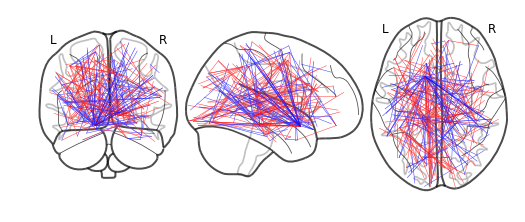

In [8]:
# use nilearn's plot_connectome function to visualize the weights
weight_mtx=weight_mtx_from_utr(weights)
nilearn.plotting.plot_connectome(weight_mtx, parceldata.iloc[:,2:5],
                                edge_threshold='99.9%',
                                node_size=0,
                                edge_kwargs={'linewidth':0.5})


As you can see, it's somewhat difficult to discern much by looking at the connections projected via a 3-d projection. Another alternative is to use the fact that function connectivity can be characterized in terms of a number of large-scale networks, and summarize the weights in terms of their networks.

In the myconnectome data we already have a set of network assignments (based on the earlier work of Power et al) so let's start with those.  First let's visualize the networks.

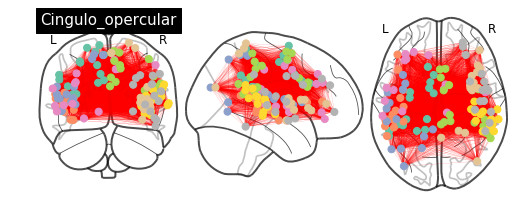

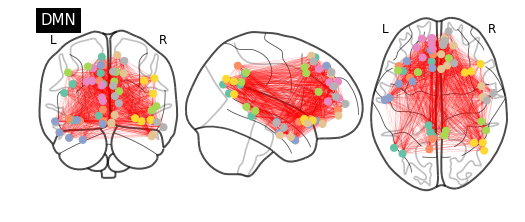

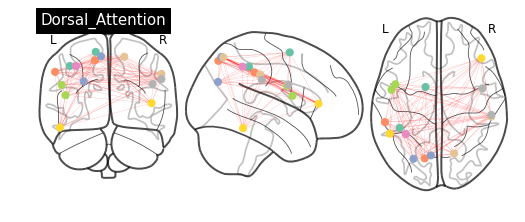

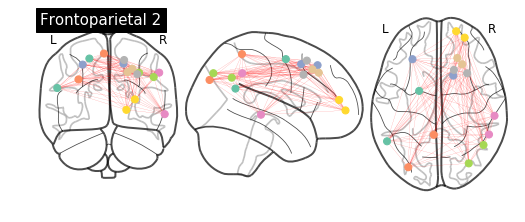

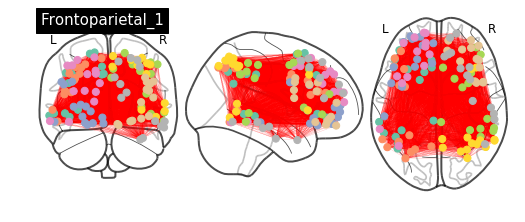

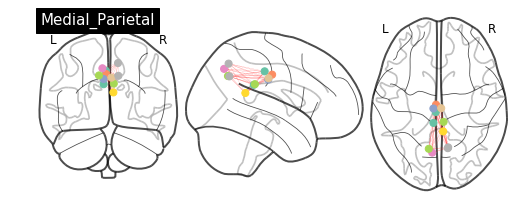

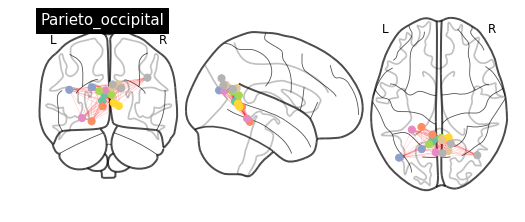

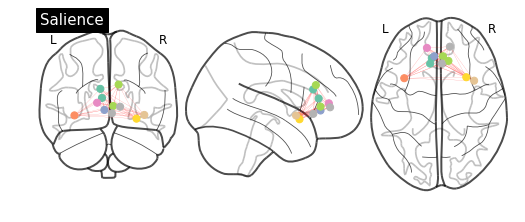

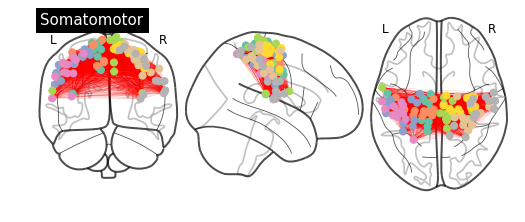

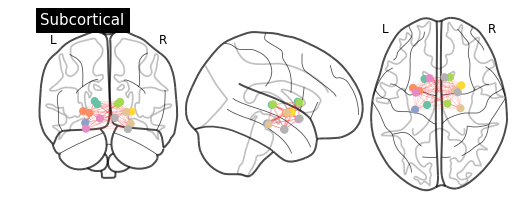

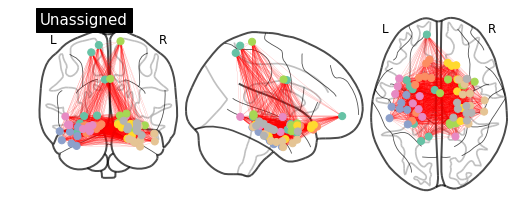

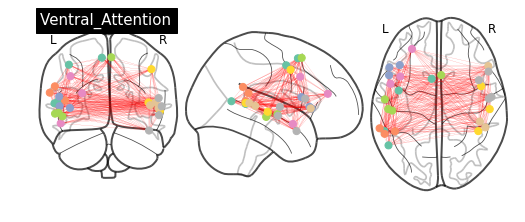

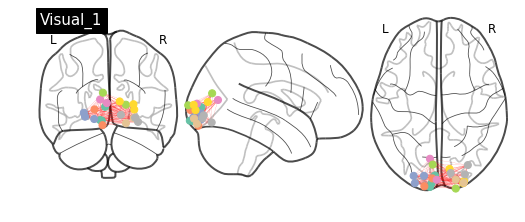

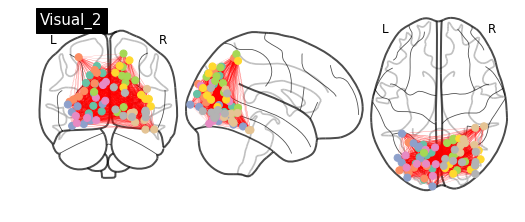

In [9]:
for network in numpy.unique(parceldata.iloc[:,7]):
    adjmtx=numpy.ones((630,630))
    network_matches=parceldata.iloc[:,7].values==network
    adjmtx=adjmtx[network_matches,:]
    adjmtx=adjmtx[:,network_matches]
    nilearn.plotting.plot_connectome(adjmtx, parceldata.iloc[network_matches,2:5],
                                title=network,
                                edge_kwargs={'linewidth':0.1})


Now let's look at how weights map to the connections within and between these networks.  First we create a function that takes in a set of weights and summarizes them across all combinations of networks.

In [10]:
def parcelmap(weights,parceldata,show_image=True):
    parcel_networks=parceldata.iloc[:,7].values
    networks=numpy.unique(parcel_networks)
    n_networks=len(networks)
    colnetworkmtx=numpy.tile(parcel_networks,(630,1))
    colnetworkmtx[numpy.diag_indices_from(colnetworkmtx)]='none'
    rownetworkmtx=colnetworkmtx.T

    # create full weight matrix from upper triangle
    weight_mtx=weight_mtx_from_utr(weights)

    # summarize weights by networks

    network_mtx=numpy.zeros((n_networks,n_networks))
    for i in range(n_networks):
        for j in range(n_networks):
            match=numpy.where((rownetworkmtx==networks[i]) * (colnetworkmtx==networks[j]))
            matchmtx=weight_mtx[match]
            network_mtx[i,j]=numpy.mean(matchmtx)
            
    if show_image:
        plt.figure(figsize=(8,8))
        plt.imshow(network_mtx)
        plt.colorbar()
        ax=plt.gca()
        ax.set_yticks(numpy.arange(0,14))
        ax.set_yticklabels(networks)
        plt.xticks(numpy.arange(0,14), rotation='vertical')
        ax.set_xticklabels(networks)

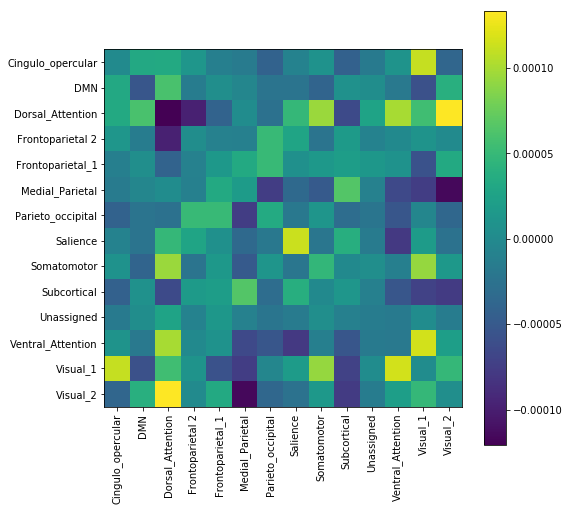

In [11]:
parcelmap(weights,parceldata)

From this we can see that it's the visual and somatomotor networks and their interconnections that are positively associated with fatigue, and dorsal attention and medial parietal networks that are negatively associated with fatigue.

### Identifying resting state networks

The networks listed above were based on the use of a network clustering (or "community detection") algorithm, which identifies sets of nodes that are more strongly connected with one another than they are with other regions.  There are a number of methods for doing this; we used a method called infomap (code available at https://github.com/mapequation/infomap).  This is implemented within the igraph library.

In [12]:
density=0.05
meancorr=numpy.mean(corrdata,0)
cutoff=scipy.stats.scoreatpercentile(meancorr,100-density*100)
adjmtx=weight_mtx_from_utr(corrdata)
adjmtx[adjmtx<cutoff]=0
adjmtx[adjmtx>0]=1

G = igraph.Graph.Adjacency(adjmtx.tolist(),mode='UNDIRECTED')
print(G.summary())
# save original indices
parcel_networks=parceldata.iloc[:,7].values
for v in G.vs:
    v['origindex']=v.index
    v['powernetwork']=parcel_networks[v.index]
vc = G.components() ##Get VertexClustering object
G_gc=vc.giant()
print(G_gc.summary())

IGRAPH U--- 630 9907 -- 
IGRAPH U--- 566 9889 -- 
+ attr: origindex (v), powernetwork (v)


In [13]:
community=G_gc.community_infomap(trials=100)
for v in G_gc.vs:
    v['infomap']=community.membership[v.index]

print(numpy.unique(community.membership))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Let's look at the networks identified using infomap and compare them to the networks identified by Laumann and colleagues (who used a fancier consensus clustering method that combined across different network densities).

In [14]:
for c in numpy.unique(community.membership):
    powernets=[node['powernetwork'] for node in G_gc.vs if node['infomap']==c]
    df=pandas.DataFrame({'OrigNetwork':powernets})
    print('infomap community %d'%c)
    print(df.groupby('OrigNetwork').size().sort_values(ascending=False))
    print('')

infomap community 0
OrigNetwork
Frontoparietal_1    105
Dorsal_Attention      8
Frontoparietal 2      7
DMN                   2
Unassigned            1
dtype: int64

infomap community 1
OrigNetwork
Cingulo_opercular    102
Somatomotor            3
Unassigned             1
Salience               1
Frontoparietal 2       1
Dorsal_Attention       1
dtype: int64

infomap community 2
OrigNetwork
Somatomotor          86
Unassigned            3
Dorsal_Attention      2
Visual_2              1
Cingulo_opercular     1
dtype: int64

infomap community 3
OrigNetwork
Visual_2             63
Visual_1              2
Parieto_occipital     1
Dorsal_Attention      1
dtype: int64

infomap community 4
OrigNetwork
DMN                  46
Salience             10
Frontoparietal 2      3
Parieto_occipital     2
Frontoparietal_1      1
Cingulo_opercular     1
dtype: int64

infomap community 5
OrigNetwork
Ventral_Attention    22
DMN                   4
Frontoparietal_1      2
Unassigned            1
dtype: int64

Now let's plot a two-dimensional projection of the data. 

In [15]:
pal = igraph.drawing.colors.ClusterColoringPalette(len(community))
G_gc.vs['color'] = pal.get_many(community.membership)
visual_style = {"vertex_size":8}
igraph.plot(G_gc, layout="fr",**visual_style)